# KL-divergence (Chapter 4)

This notebook covers the code to generate Figures 4.2 and 4.3 in Chapter 4 of the textbook "Fundamentals of Active Inference".

==========================================================================
* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

*This Jupyter notebook should only be distributed to members of the "Fundamentals of Active Inference" reading group hosted by the Active Inference Institute.*

Package versions:
* matplotlib==3.5.3
* numpy==1.21.5
* pyro-ppl==1.8.4
* pytorch==1.13.1

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import torch

from pyro.distributions import Normal

plt.rcParams.update({
    "figure.dpi": 120})

mpl.style.use("seaborn-deep")

## Comparing two normal distributions with KL-divergence

Many useful functions and operators from information theory give us summaries about the relationship between one or more probability distributions. These functions will take a probability distribution, or multiple probability distributions, as input, and return a single value. KL divergence is defined as follows:

$$
D_{KL}(p(a) \parallel p(b)) = \int p(a) \log \frac{p(a)}{p(b)} da
$$

However, sometimes it is easier to split the log division into subtraction using the *quotient rule for logarithms* and then rewrite interms of expected value. Then we obtain

$$
D_{KL}(p(a) \parallel p(b)) = \mathbb{E}_{p(a)} \left [\log p(a) - \log p(b) \right ]
$$

The formula indicates that KL-divergence is the *average log difference*, taken with respect to the first probability distribution. Since difference can be thought of as a measure of distance, it is like taking the (log) average distance between each point of one probability distribution relative to another. If the distributions are identical then KL-divergence will be zero.

In order to show the calculation of KL-divergence, we need to first define two probability distributions with different means and variances that we wish to compare. In the example below, $p(a)$ will start as $\mathcal{N}(\mu=-1, \sigma=1.5)$. It will be progressively changed as we compare it to $p(b) = \mathcal{N}(\mu=0, \sigma=0.5)$ which will stay the same over the different plots.

In [2]:
a_range = torch.linspace(-6, 6, 500)   # Range of first distribution
b_range = torch.linspace(-6, 6, 500)   # Range of second distribution

p_b     = torch.exp(Normal(loc=0, scale = 0.5).log_prob(b_range))

# First comparison
p_a_1   = torch.exp(Normal(loc=-1, scale = 1.5).log_prob(a_range))
p_b_1   = p_b

# Second comparison
p_a_2   = torch.exp(Normal(loc=-1, scale = 0.8).log_prob(a_range))
p_b_2   = p_b

# Third comparison
p_a_3   = torch.exp(Normal(loc=1.5, scale = 0.5).log_prob(a_range))
p_b_3   = p_b

# Fourth comparison
p_a_4   = torch.exp(Normal(loc=0, scale = 0.5).log_prob(a_range))
p_b_4   = p_b

Now we are ready to create a function for KL-divergence. In some cases, the probability may be zero. To avoid taking the log of $0$ which would return `-inf`, we add a small value of `1e-8` to any zero values. Since we are approximating the distribution by dividing it into small chunks along its input range, we are able to use the `torch.sum()` function instead of integrating.

In [3]:
def kl_divergence(p_a: torch.tensor, p_b: torch.tensor, stable: bool=True) -> float:
    
    # Stabilize zero values so they don't go to inf when taking log
    if stable:
        eps = 1e-8
        p_a[p_a == 0] = eps
        p_b[p_b == 0] = eps
    
    # Compute KL divergence
    return torch.sum(p_a * (torch.log(p_a) - torch.log(p_b)))

In [4]:
kl_1 = kl_divergence(p_a_1, p_b_1)
kl_2 = kl_divergence(p_a_2, p_b_2)
kl_3 = kl_divergence(p_a_3, p_b_3)
kl_4 = kl_divergence(p_a_4, p_b_4)

<Figure size 768x576 with 0 Axes>

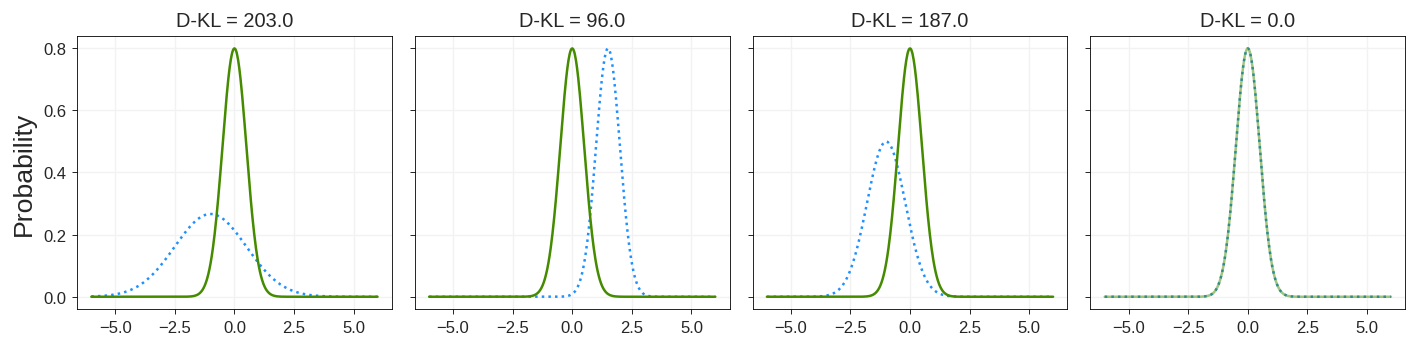

In [5]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(1, 4, facecolor=(1,1,1), figsize=(12, 3), sharey=True)

# Main plot
axes[0].plot(a_range, p_a_1, c="#1E90FF", linestyle=":")
axes[0].plot(b_range, p_b_1, c="#458B00")
axes[2].plot(a_range, p_a_2, c="#1E90FF", linestyle=":")
axes[2].plot(b_range, p_b_2, c="#458B00")
axes[1].plot(a_range, p_a_3, c="#1E90FF", linestyle=":")
axes[1].plot(b_range, p_b_3, c="#458B00")
axes[3].plot(a_range, p_a_4, c="#1E90FF", linestyle=":")
axes[3].plot(b_range, p_b_4, c="#458B00", alpha=0.5)


# Titles
axes[0].set_title(f"D-KL = {torch.round(kl_1)}")
axes[1].set_title(f"D-KL = {torch.round(kl_2)}")
axes[2].set_title(f"D-KL = {torch.round(kl_3)}")
axes[3].set_title(f"D-KL = {torch.round(kl_4)}")

# Axis global labels
fig.supylabel("Probability", fontsize=16)

# Cosmetic changes and axes ranges
for ax in axes:
    # ax.xaxis.set_ticks(np.arange(0, 6, 1))
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)
    
fig.tight_layout()

We can see that KL-divergence is at 0 when the distributions are identical.

## KL divergence is minimized when the distributions have the same parameters

What if we were to keep $p(b)$ fixed and then vary the mean and standard deviation of $p(a)$ over different ranges? Then we could visualize all at once the full range of KL-divergence as a function of the mean and standard deviation of $p(a)$. We would expect that this 3D plot would have a minima at the point where the mean and standard deviation of the two distributions match. 

First we create the `kl_over_parameters()` function to compute KL-divergence as a function of the mean and standard deviation of $p(a)$.

In [7]:
def kl_over_parameters(mu, sigma):
    p_a = torch.exp(Normal(loc=mu, scale = sigma).log_prob(a_range))
    p_b = torch.exp(Normal(loc=0, scale = 0.5).log_prob(b_range))
    return kl_divergence(p_a, p_b)

Now we vectorize this function and pass in the ranges of values we wish to compute KL-divergence over.

/home/sanjeev/anaconda3/envs/ds_env_1/lib/python3.9/site-packages/numpy/lib/function_base.py:2246: RuntimeWarning: invalid value encountered in kl_over_parameters (vectorized)
  outputs = ufunc(*inputs)


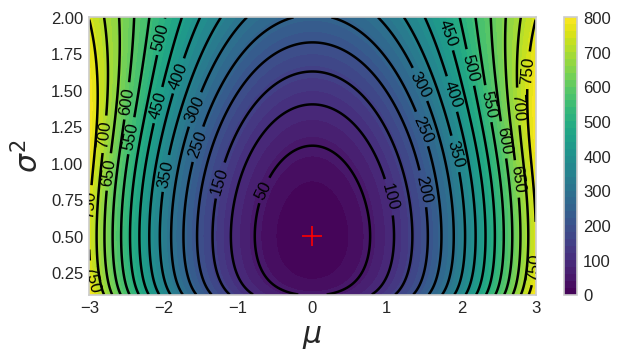

In [8]:
plt.style.use("seaborn-whitegrid")
fig, ax = plt.subplots(1,1, facecolor=(1,1,1), figsize=(6, 3))

# Set up grid
mu_range = np.linspace(-3, 3, 200)
sigma_range = np.linspace(0.1, 2, 200)
X, Y = np.meshgrid(mu_range, sigma_range)

# Vectorize NLL and compute the costs at all combinations of beta_0 and beta_1
kl_param_vec = np.vectorize(kl_over_parameters)
z = kl_param_vec(X, Y)

# Plot the contours of the costs and fill them in
contours = ax.contour(X, Y, z, levels=15, colors='k')
fill = ax.contourf(X, Y, z, levels=50, cmap="viridis")

# True parameters of p_b
ax.plot(0, 0.5, marker="+", color="red", markersize=12)   # True generating parameters

# Axis labels
ax.set_xlabel(r'$\mu$', fontsize=18)
ax.set_ylabel(r'$\sigma^2$', fontsize=18)

# Labels contours and add colorbar
plt.clabel(contours)
plt.colorbar(fill)

In this contour plot, the color bar indicates KL-divergence. We can see that KL-divergence becomes zero when the mean of $p(a)$ is $0$ and the standard deviation is $0.5$.